# ARBRES DE GRENOBLE - Etape 2

# 1 Données

## 1.1 Données brutes

In [1]:
import pandas as pd
import numpy as np

In [2]:
def clean_trees_data(file, percent=80, min_item_number=5, print_columns_dropped=False):
    '''
    Fonction permettant de d'importer les données csv, de les traiter et de les stocker au format pkl.
    'File' indique le nom du fichier à importer.
    'percent' indique le pourcentage (100 = max) de valeurs manquantes pour lequel certaines colonnes doivent être supprimées. La valeur par défaut est 80.
    'min_item_number' indique, pour une colonne catégorielle, le nombre d'observation minimal d'un item pour qu'il soit classé comme 'Others'. La valeur par défaut est 5.
    'print_columns_dropped' affiche les colonnes supprimées durant le nettoyage.
    '''

    # Load data
    df = pd.read_csv(f'./data/{file}.csv', sep=',', header = 0, index_col=False,names=None)

    # Delete empty rows and columns
    df = df.dropna(how='all').dropna(how='all', axis=1)

    # Delete columns without usefull information
    columns_to_drop = ['elem_point_id', 'code', 'nom', 'genre', 'genre_desc', 'categorie', 'categorie_desc', 'sous_categorie_desc', 'code_parent_desc', 'bien_reference']
    if print_columns_dropped:
        print("Colonnes sans informations pertinentes supprimées : \n", columns_to_drop)
    df = df.drop(columns=columns_to_drop)
    
    # Delete columns which have missing values above a given percent
    percent_of_na = pd.DataFrame(df.isna().sum())
    percent_of_na.columns = ['percent']
    percent_of_na.percent = percent_of_na.percent*100/len(df)
    columns_with_percent_missing = percent_of_na[percent_of_na['percent']>percent].index.tolist()
    columns_to_drop = []
    columns_to_drop.extend(columns_with_percent_missing)
    df = df.drop(columns=columns_to_drop)
    if print_columns_dropped:
        print(f"\n Colonnes supprimées ayant plus de {percent}% de valeurs manquantes : \n", percent_of_na[percent_of_na['percent']>percent])

    # Location columns
    df[['geo_point_longitude', 'geo_point_latitude']] = df['geo_point_2d'].str.split(",", expand = True)
    df[['geo_point_longitude', 'geo_point_latitude']] = df[['geo_point_longitude', 'geo_point_latitude']].apply(pd.to_numeric)
    df = df.drop(columns='geo_point_2d')

    # Delete missing values for 'anneedeplantation'
    df = df.dropna(subset=['anneedeplantation'])

    # Manage string columns with multiple items
    for col in df.select_dtypes(exclude=[np.number]).columns:
        unique_values = df[[col,'geo_point_longitude']].groupby(col).count()
        if unique_values['geo_point_longitude'].min() <= min_item_number:
            items = unique_values.index[unique_values['geo_point_longitude'] <= min_item_number].tolist()
            for row in items:
                df[col] = df[col].replace(row,'Others')
    
    df.to_pickle("./data/trees.pkl")

In [3]:
clean_trees_data('arbres_grenoble_epsg4326', 50)
df = pd.read_pickle("./data/trees.pkl")
print("Pourcentage de valeurs manquantes : \n", df.isna().sum()*100/len(df), "\n"*2)
print('\n'*2, df.info())

Pourcentage de valeurs manquantes : 
 sous_categorie           0.000000
code_parent              0.000000
adr_secteur              0.000000
genre_bota               0.086253
espece                   4.614517
stadededeveloppement     7.576964
anneedeplantation        0.000000
collectivite             0.650212
hauteurarbre            33.668392
structure                0.729830
geo_point_longitude      0.000000
geo_point_latitude       0.000000
dtype: float64 


<class 'pandas.core.frame.DataFrame'>
Index: 30144 entries, 0 to 31735
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sous_categorie        30144 non-null  object 
 1   code_parent           30144 non-null  object 
 2   adr_secteur           30144 non-null  int64  
 3   genre_bota            30118 non-null  object 
 4   espece                28753 non-null  object 
 5   stadededeveloppement  27860 non-null  object 
 6   anneedeplantation  

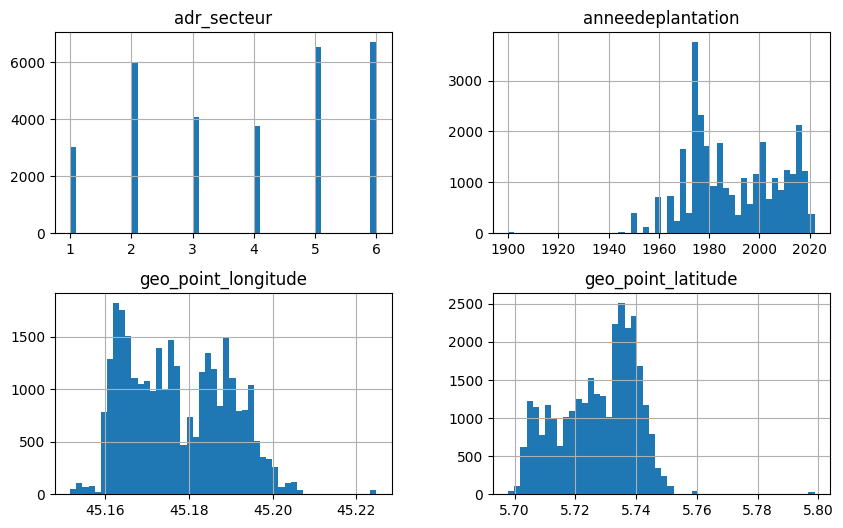

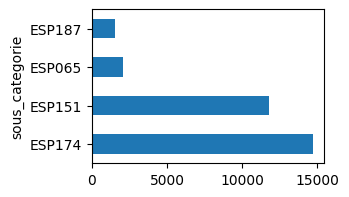


 code_parent:             Number
count  1161.000000
mean     25.963824
std      41.403757
min       6.000000
25%      10.000000
50%      16.000000
75%      28.000000
max     941.000000

 genre_bota:             Number
count    89.000000
mean    338.404494
std     767.989446
min       6.000000
25%      15.000000
50%      73.000000
75%     306.000000
max    4966.000000

 espece:             Number
count   190.000000
mean    151.331579
std     358.302716
min       6.000000
25%      11.000000
50%      33.500000
75%     143.250000
max    3739.000000


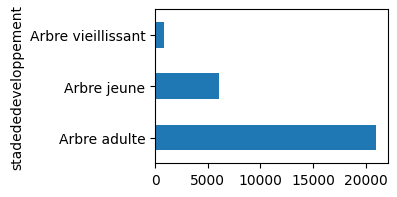

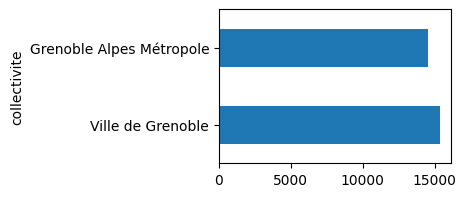

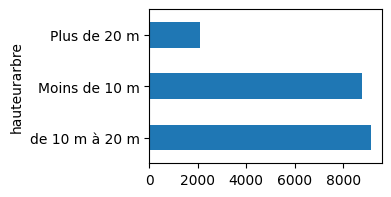

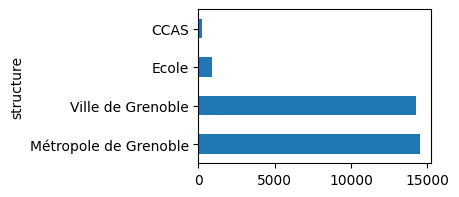

In [4]:
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(10,6))
plt.show()

for col in df.select_dtypes(include=['object']):
    if df[col].nunique() < 20:
        df[col].value_counts().plot(kind='barh', figsize=(3,2))
        plt.show()
    else:
        unique_values = df[[col,'geo_point_longitude']].groupby(col).count()
        unique_values.columns = ['Number']
        print(f"\n {col}:", unique_values.describe())

<Axes: xlabel='geo_point_latitude', ylabel='geo_point_longitude'>

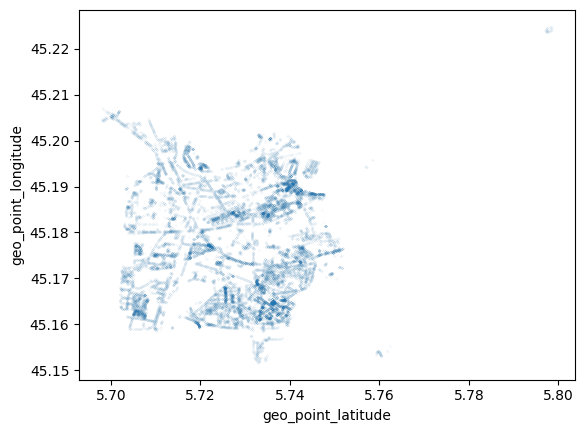

In [59]:
df[['geo_point_longitude','geo_point_latitude']].plot(kind='scatter', x='geo_point_latitude', y='geo_point_longitude', s=0.001)

## 1.2 Données test - Données d'entrainement

In [5]:
np.random.seed(42)

X = df.drop('anneedeplantation', axis=1)
y = df['anneedeplantation'].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print("Nombre d'observation dans les données d'entrainement =", len(X_train))
print("Nombre d'observation dans les données test =", len(X_test))

Nombre d'observation dans les données d'entrainement = 24115
Nombre d'observation dans les données test = 6029


## 1.3 Préparer les données pour le Machine Learning

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('encoder', OneHotEncoder()),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

#numerical_features = X_train.select_dtypes(include=[np.number]).columns
numerical_features = make_column_selector(dtype_include=np.number)
#X_train_cat = X_train.select_dtypes(exclude=[np.number]).columns
categorical_features = make_column_selector(dtype_exclude=np.number)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
print("Taille des données d'entrainement préparées :", X_train_prepared.shape)

Taille des données d'entrainement préparées : (24115, 1465)


In [8]:
X_test_prepared = full_pipeline.transform(X_test)
print("Taille des données test préparées :", X_test_prepared.shape)

Taille des données test préparées : (6029, 1465)


# 2 Former et évaluer les modèles ML

### 2.0 Modèle naïf

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_median = [y_train.mean()]*len(y_train)
naif_rmse = mean_squared_error(y_train, y_median, squared=False)
print(f"L'erreur de prédiction du modèle naïf est d'environ {round(naif_rmse,2)}, en utilisant le RMSE.")

L'erreur de prédiction du modèle naïf est d'environ 17.99, en utilisant le RMSE.


### 2.1 Modèle linéaire

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [11]:
X_train_predictions = lin_reg.predict(X_train_prepared)
lin_rmse = mean_squared_error(y_train, X_train_predictions, squared=False)
print(f"L'erreur de prédiction du modèle est d'environ {round(lin_rmse,2)}, en utilisant le RMSE.")
lin_mae = mean_absolute_error(y_train, X_train_predictions)
print(f"Avec le MAE, l'erreur est d'environ {round(lin_mae, 2)} ans.")

L'erreur de prédiction du modèle est d'environ 7.19, en utilisant le RMSE.
Avec le MAE, l'erreur est d'environ 4.5 ans.


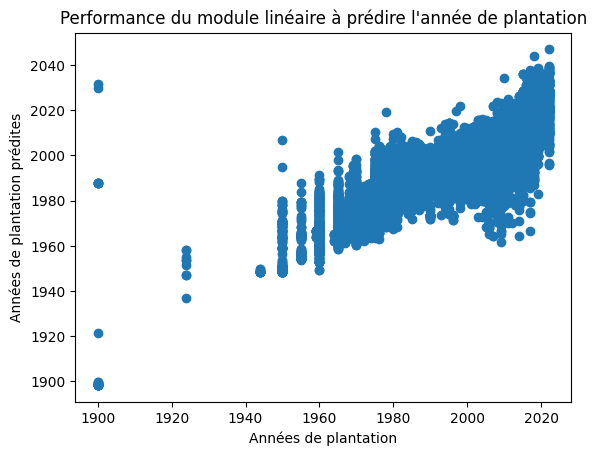

In [12]:
plt.scatter(y_train, X_train_predictions)
plt.xlabel("Années de plantation")
plt.ylabel("Années de plantation prédites")
plt.title("Performance du module linéaire à prédire l'année de plantation")
plt.show()

### 2.2 Arbre de décision

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_prepared, y_train)

DecisionTreeRegressor()

In [14]:
X_train_predictions = tree_reg.predict(X_train_prepared)
tree_rmse = mean_squared_error(y_train, X_train_predictions, squared=False)
print(f"L'erreur de prédiction avec l'arbre de décision est d'environ {round(tree_rmse,2)}, en utilisant le RMSE.")
print("Ce résultat ...")

L'erreur de prédiction avec l'arbre de décision est d'environ 0.0, en utilisant le RMSE.
Ce résultat ...


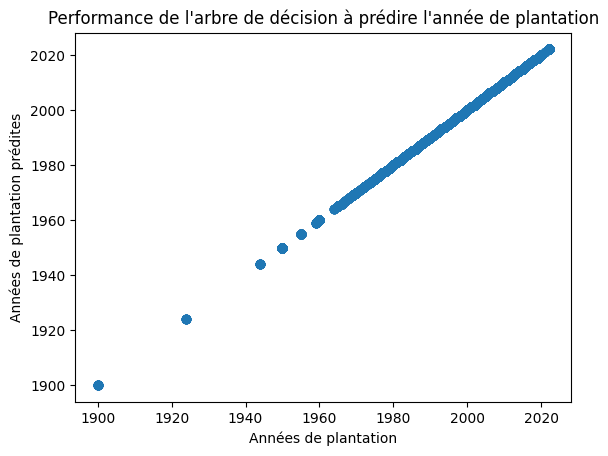

In [15]:
plt.scatter(y_train, X_train_predictions)
plt.xlabel("Années de plantation")
plt.ylabel("Années de plantation prédites")
plt.title("Performance de l'arbre de décision à prédire l'année de plantation")
plt.show()

## 2.3 Forêt aléatoire

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(X_train_prepared, y_train)

RandomForestRegressor(n_jobs=-1)

In [17]:
X_train_predictions = forest_reg.predict(X_train_prepared)
forest_rmse = mean_squared_error(y_train, X_train_predictions, squared=False)
print(f"L'erreur de prédiction avec l'arbre de décision est d'environ {round(forest_rmse,2)}, en utilisant le RMSE.")
forest_mae = mean_absolute_error(y_train, X_train_predictions)
print(f"Avec le MAE, l'erreur est d'environ {round(forest_mae,2)} ans.")

L'erreur de prédiction avec l'arbre de décision est d'environ 2.01, en utilisant le RMSE.
Avec le MAE, l'erreur est d'environ 0.68 ans.


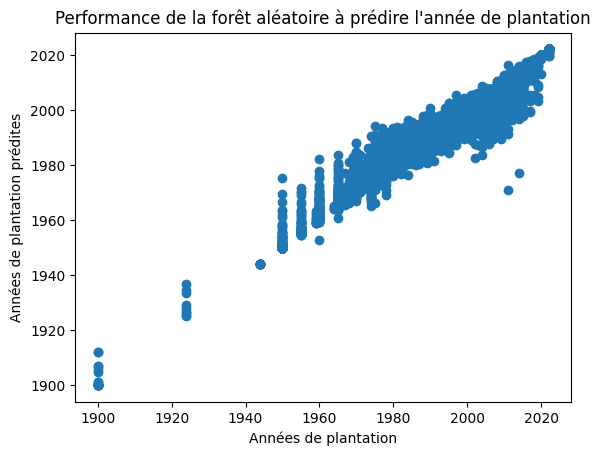

In [18]:
plt.scatter(y_train, X_train_predictions)
plt.xlabel("Années de plantation")
plt.ylabel("Années de plantation prédites")
plt.title("Performance de la forêt aléatoire à prédire l'année de plantation")
plt.show()

## 2.4 Support Vector Machine

In [19]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(dual='auto', C=1)
svm_reg.fit(X_train_prepared, y_train)

LinearSVR(C=1, dual='auto')

In [20]:
#from sklearn.svm import SVR

#svm_reg = SVR(kernel="poly", degree=2)
#svm_reg.fit(X_train_prepared, y_train)

In [21]:
X_train_predictions = svm_reg.predict(X_train_prepared)
svm_rmse = mean_squared_error(y_train, X_train_predictions, squared=False)
print(f"L'erreur de prédiction avec le SVR est d'environ {round(svm_rmse,2)}, en utilisant le RMSE.")
svm_mae = mean_absolute_error(y_train, X_train_predictions)
print(f"Avec le MAE, l'erreur est d'environ {round(svm_mae,2)} ans.")

L'erreur de prédiction avec le SVR est d'environ 19.43, en utilisant le RMSE.
Avec le MAE, l'erreur est d'environ 6.23 ans.


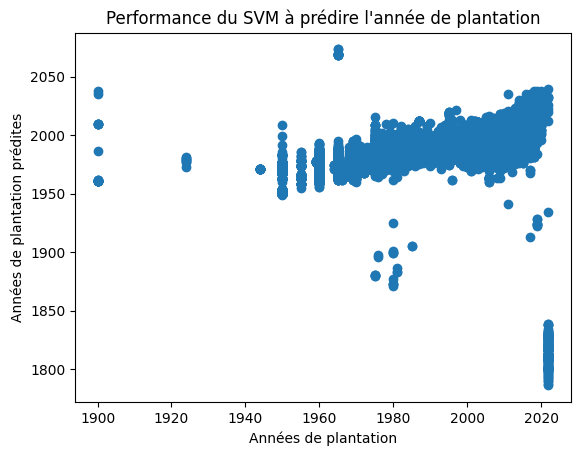

In [22]:
plt.scatter(y_train, X_train_predictions)
plt.xlabel("Années de plantation")
plt.ylabel("Années de plantation prédites")
plt.title("Performance du SVM à prédire l'année de plantation")
plt.show()

## 2.5 Cross-Validation

In [23]:
from sklearn.model_selection import cross_val_score

def display_scores(model, cv):
    scores = cross_val_score(model, X_train_prepared, y_train,
                         scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
    rmse = np.sqrt(-scores)
    return model, rmse.mean(), rmse.std()

In [24]:
models = [lin_reg, tree_reg, forest_reg, svm_reg]
results = []

for i in models:
    results.append(display_scores(i, 10))

In [25]:
cross_validation = pd.DataFrame(results)
cross_validation.columns = ['Model', 'Mean', 'Std']
cross_validation.sort_values('Mean')

,Model,Mean,Std
2,"(DecisionTreeRegressor(max_features=1.0, rando...",5.474393,0.228570
1,DecisionTreeRegressor(),6.887572,0.321696
0,LinearRegression(),7.699187,0.313538
3,"LinearSVR(C=1, dual='auto')",22.243520,2.622462


In [26]:
model_rmse = cross_validation['Mean'].min()

In [27]:
import joblib

joblib.dump(lin_reg, "./data/lin_reg.pkl")
joblib.dump(tree_reg, "./data/tree_reg.pkl")
joblib.dump(forest_reg, "./data/forest_reg.pkl")
joblib.dump(svm_reg, "./data/svm_reg.pkl")

['./data/svm_reg.pkl']

# 3 Affiner le modèle

### 3.1 Grid Search

In [44]:
from sklearn.model_selection import GridSearchCV

#param_grid = [
#    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
#    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
#  ]
param_grid = [
    {'n_estimators': [300, 600], 'max_features': [4, 6, 8, 12]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           n_jobs=-1)
grid_search.fit(X_train_prepared, y_train)

/home/timothee.coulibaly@Digital-Grenoble.local/anaconda3/envs/ML/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [4, 6, 8, 12],
                          'n_estimators': [300, 600]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [46]:
grid_search.best_params_

{'max_features': 12, 'n_estimators': 600}

In [47]:
cvres = grid_search.cv_results_
results = []

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    result = np.sqrt(-mean_score), params
    results.append(result)

gridsearch = pd.DataFrame(results)
gridsearch.columns = ['Mean', 'Parameters']
gridsearch.sort_values('Mean')

,Mean,Parameters
7,5.441785,"{'max_features': 12, 'n_estimators': 600}"
2,5.444419,"{'max_features': 6, 'n_estimators': 300}"
6,5.447942,"{'max_features': 12, 'n_estimators': 300}"
3,5.451834,"{'max_features': 6, 'n_estimators': 600}"
1,5.456654,"{'max_features': 4, 'n_estimators': 600}"
5,5.467218,"{'max_features': 8, 'n_estimators': 600}"
0,5.467482,"{'max_features': 4, 'n_estimators': 300}"
4,5.478473,"{'max_features': 8, 'n_estimators': 300}"


In [31]:
print("Meilleurs modèles comparativement au modèle initial : \n")
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if np.sqrt(-mean_score) < model_rmse:
        print(np.sqrt(-mean_score), params)

Meilleurs modèles comparativement au modèle initial : 



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

### 3.2 Evaluation du modèle sur les données test

In [34]:
#final_model = grid_search.best_estimator_

forest_reg = RandomForestRegressor(n_jobs=-1)
forest_reg.fit(X_test_prepared, y_test)
final_model = forest_reg

final_predictions = final_model.predict(X_test_prepared)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f"L'erreur de prédiction avec le modèle final est d'environ {round(final_rmse,2)}, en utilisant le RMSE.")

from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
confidence_interval = np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))
print("L'intervalle de confiance pour cette valeur est : ", confidence_interval)

final_mae = mean_absolute_error(y_test, final_predictions)
print(f"\n L'erreur de prédiction est de {round(final_mae,2)} ans.")

L'erreur de prédiction avec le modèle final est d'environ 2.72, en utilisant le RMSE.
L'intervalle de confiance pour cette valeur est :  [2.56614619 2.86728302]


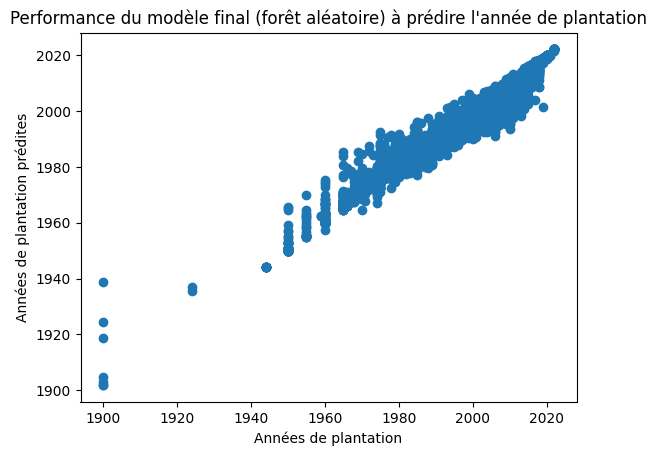

In [35]:
plt.scatter(y_test, final_predictions)
plt.xlabel("Années de plantation")
plt.ylabel("Années de plantation prédites")
plt.title("Performance du modèle final (forêt aléatoire) à prédire l'année de plantation")
plt.show()

# 4 Mémo

<span style="color:Green">

### **Erreur de prédiction**

* **Root Mean Squared Error (RMSE)** : 

$$ RMSE_{f,o} = \frac{1}{N}\sqrt{\sum_{i=1}^{N}(y_i - \hat{y}_i)^2}$$

* **Mean Absolute Error (MAE)** : 

$$ MAE = \frac{1}{N} \sum_{i=1}^{N}|y_i - \hat{y}_i|$$

[Source](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d)

### **Arbre de décision**

C'est un algorithme de Machine Learning permettant de faire une classification ou une prédiction.
Il vise à discrimiter les attributs d'un label (variable dépendante) à partir de différentes features (variables indépendantes). Il fonctionne de manière itérative. Pour une étape d'itération peut être présentée de la manière suivante :
* Dans un premier temps, en utilisant une mesure de sélection d'attributs (*Attribute Selection Measures* (ASM) : *Information Gain*, *Ratio Gain*, *Gini Index*, entre autres), il calcule une valeur pour chaque feature et retient celle ayant la valeur la plus élevée pour *Information Gain* ou *Ratio Gain* ou la plus faible avec le *Gini Index*. L'idée des ASM est de trouver, pour une feature donnée, sa capacité à discriminer les données.
* Dans un second temps, la feature étant trouvée, celle-ci sert de noeud à partir duquel les autres features sont à nouveau évaluées.
En supposant que l'objectif soit de prédire le risque d'attaque cardiaque à partir d'un ensemble de features (Age, Poids, Fumeur), une première étape permettrait de choisir la variable Age (voir graphique ci-dessous). Ensuite l'étape précédemment indiqué est repris pour chaque nouveau noeud (Poids, Fumeur). L'étape est ainsi reprise de manière itérative jusqu'à classer tous les attributs.

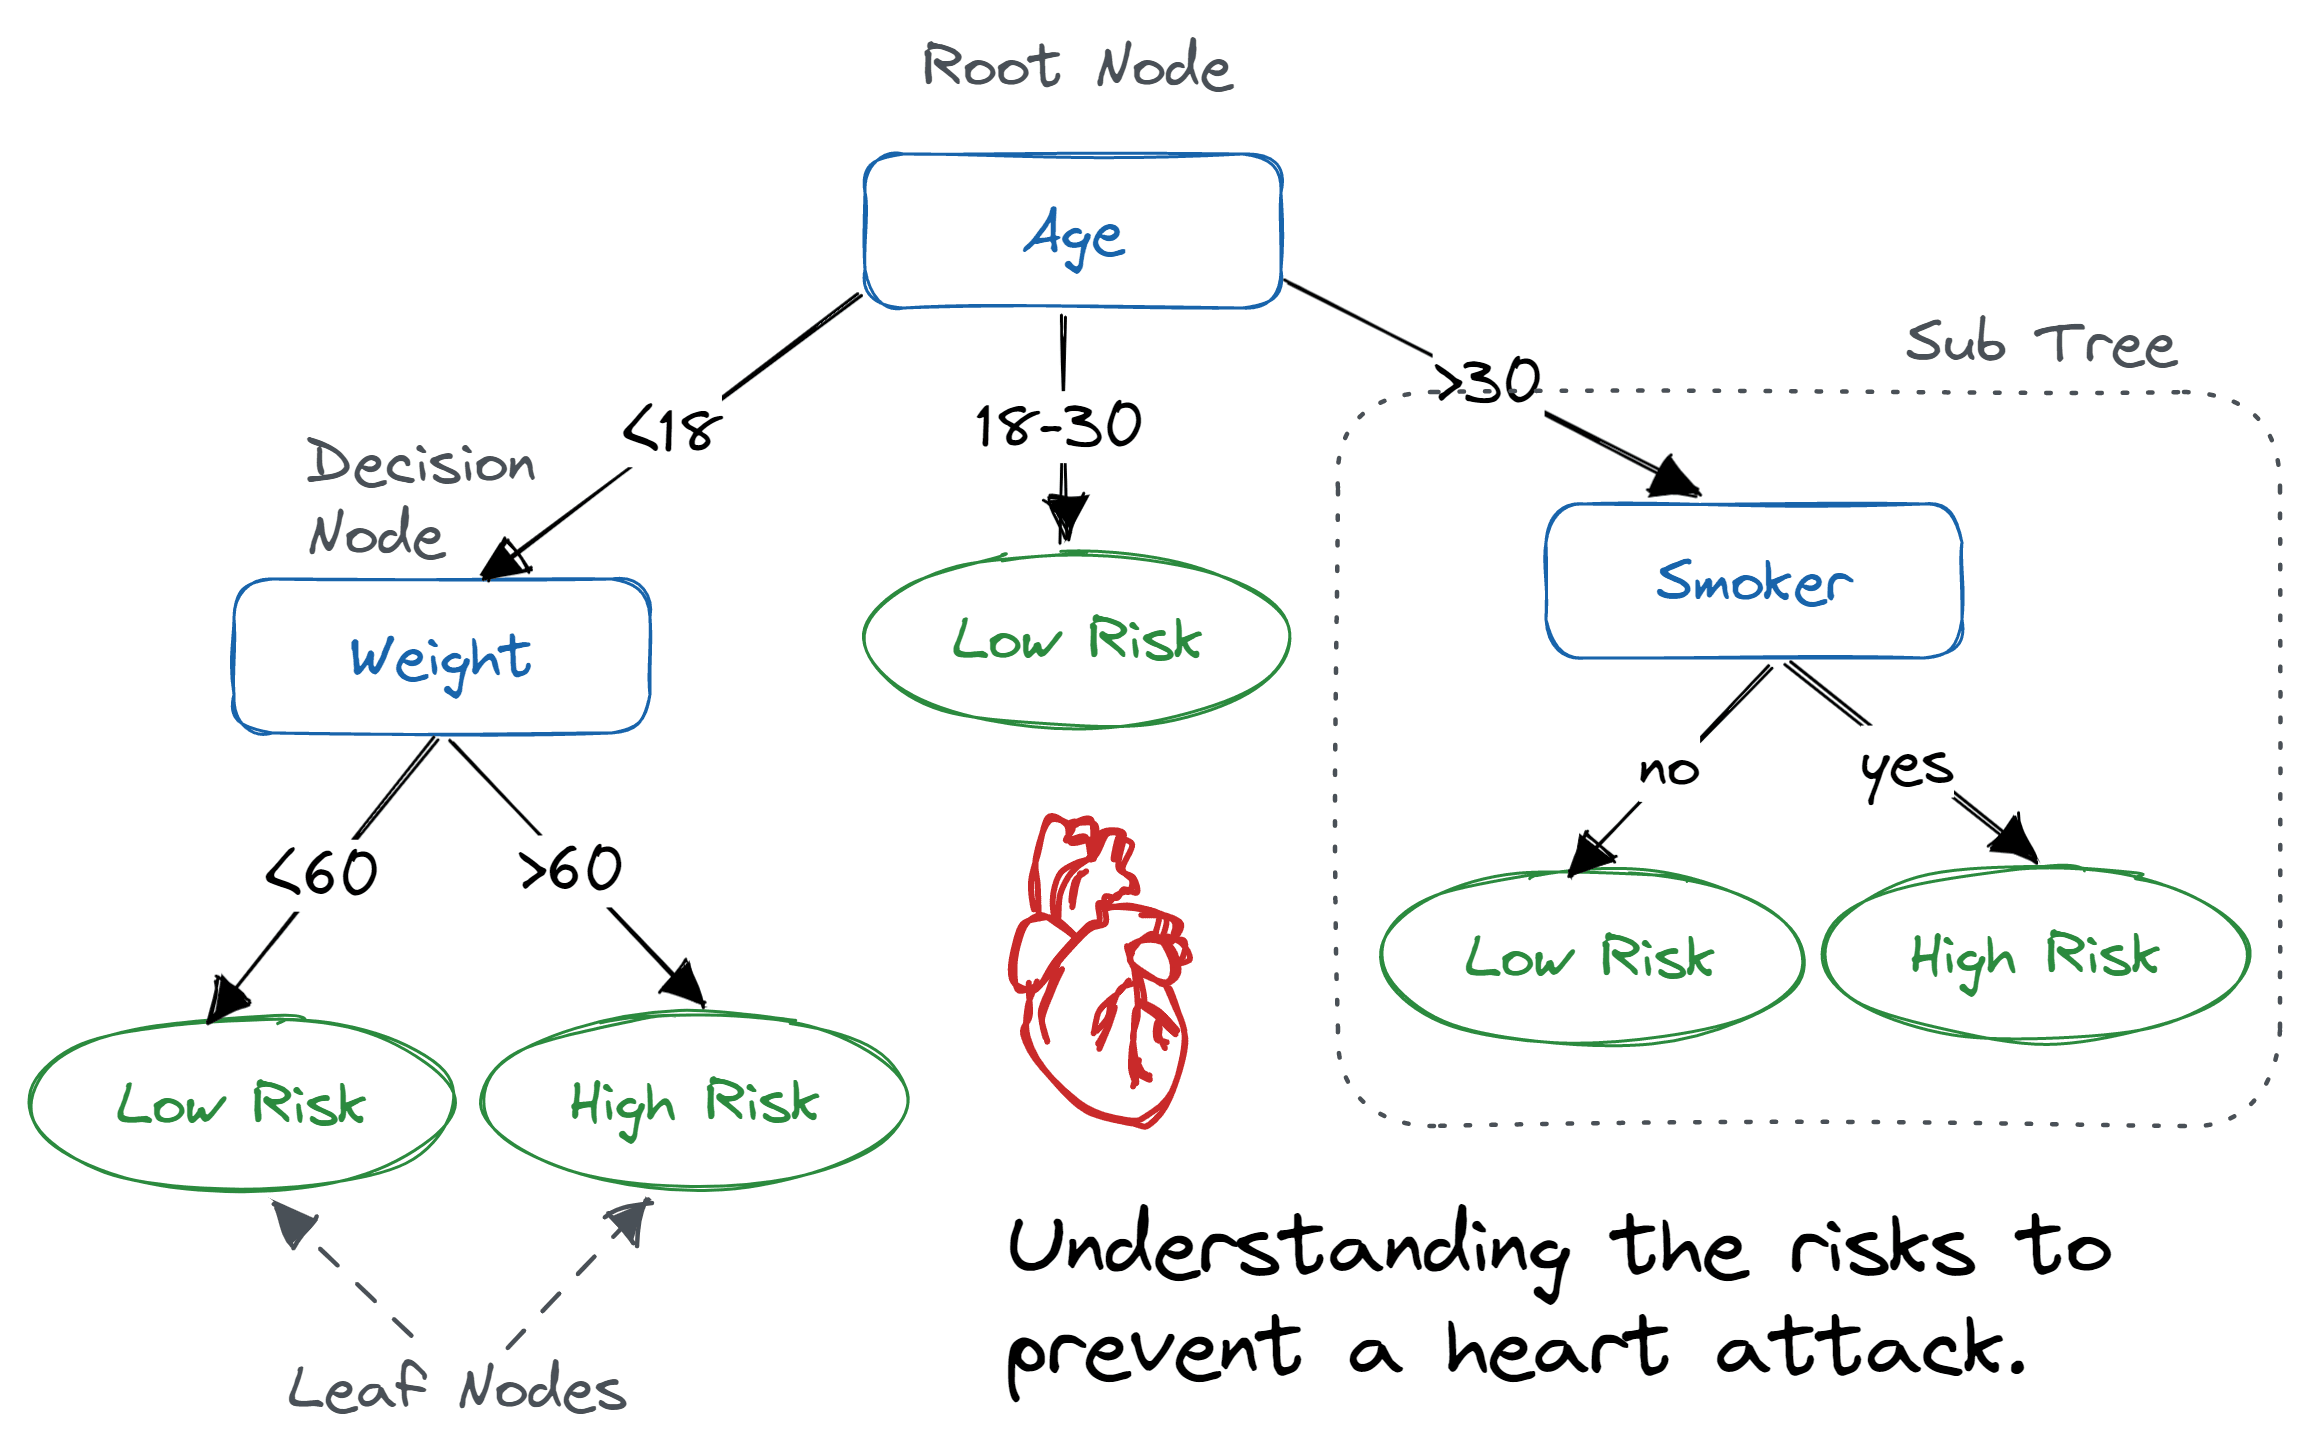

Sources
- https://www.datacamp.com/tutorial/decision-tree-classification-python
- https://towardsdatascience.com/random-forest-regression-5f605132d19d
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://www.jedha.co/formation-ia/arbre-de-decision-random-forest

### **Forêt aléatoire**


</span>